In [1]:
from astropy import units as u
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
from astropy.io import ascii

from astroplan import Observer, FixedTarget
from astroplan import (AltitudeConstraint, AirmassConstraint, AtNightConstraint)
from astroplan import is_observable, is_always_observable, months_observable
from astroplan import observability_table
from astroplan import time_grid_from_range
from astroplan.plots import plot_sky, plot_airmass, plot_altitude
import astroplan

from collections import Counter
from math import radians, cos, log10
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import cm
import pandas as pd
import warnings    

# -------------------------------------------------------- #
#  CARGAMOS EL CATÁLOGO Y DEFINIMOS LOS TARGETS A OBSERVAR #
# -------------------------------------------------------- #
    
# Cargamos las 7408 estrellas del match del catálogo con GAIA
main_catalogue_matched = Table.read('../data/catalogos/main_catalogue_matched_GAIA.csv', format='csv')

# Cargamos las 1221 estrellas a las que se les puede ver Litio
main_catalogue_0 = Table.read('../data/catalogos/Lithium.Targets.All.Physics.csv', format='csv')

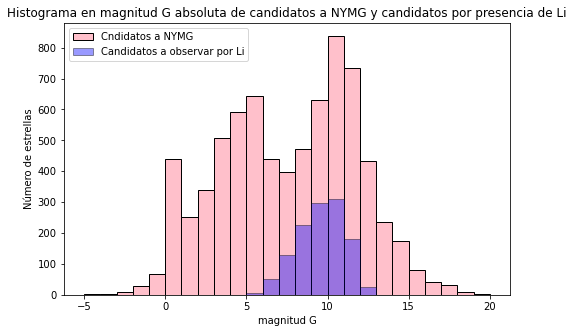

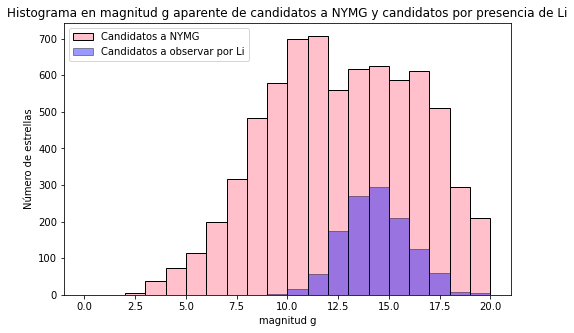

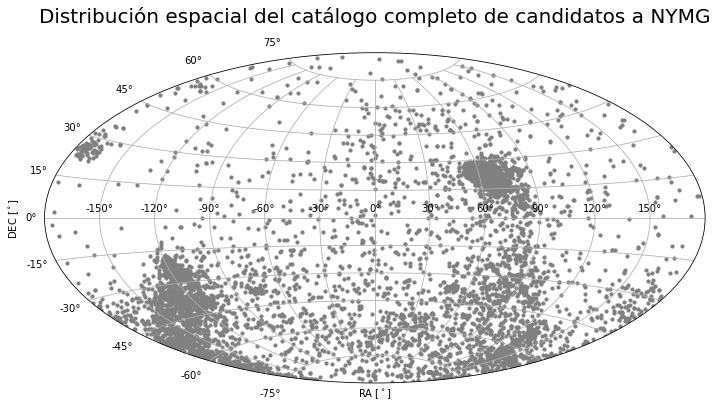

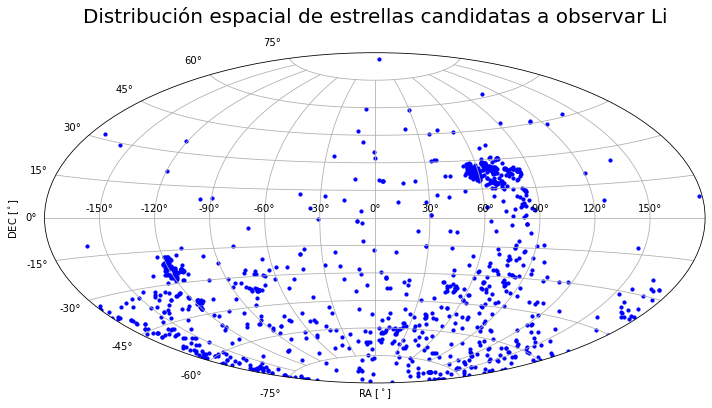

In [5]:
# -------------------------------------------------- #
#    HISTOGRAMAS DE NYMG Y CANDIDATOS A OBS LITIO    #
# -------------------------------------------------- #

# En magnitud G absoluta

plt.figure(figsize=(8,5))
plt.hist(main_catalogue_matched['phot_g_absolute_mag'],
         bins=25,
         range=(-5,20),
         stacked=True,
         facecolor='pink', edgecolor='black',
         histtype='barstacked',
         label="Cndidatos a NYMG"),
plt.hist(main_catalogue_0['phot_g_absolute_mag'],
         bins=25,
         range=(-5,20),
         stacked=True,
         facecolor='blue', edgecolor='black', alpha =0.4,
         histtype='barstacked',
         label="Candidatos a observar por Li")
plt.title("Histograma en magnitud G absoluta de candidatos a NYMG y candidatos por presencia de Li")
plt.ylabel("Número de estrellas")
plt.xlabel("magnitud G")
plt.legend(loc='best')
plt.savefig("./graphics/histograma_total_G.jpg")
plt.show()

# En magnitud g aparente,

plt.figure(figsize=(8,5))
plt.hist(main_catalogue_matched['phot_g_mean_mag'],
         bins=20,
         range=(0,20),
         stacked=True,
         facecolor='pink', edgecolor='black',
         histtype='barstacked',
         label="Candidatos a NYMG")
plt.hist(main_catalogue_0['phot_g_mean_mag'],
         bins=20,
         range=(0,20),
         stacked=True,
         facecolor='blue', edgecolor='black', alpha =0.4,
         histtype='barstacked',
         label="Candidatos a observar por Li")
plt.title("Histograma en magnitud g aparente de candidatos a NYMG y candidatos por presencia de Li")
plt.ylabel("Número de estrellas")
plt.xlabel("magnitud g")
plt.legend(loc='best')
plt.savefig("./graphics/histograma_total_g.jpg")
plt.show()
,
# Distribución espacial de todos los candidatos,
,
def sky_plot(catalogue, color):
    plt.figure(figsize=(10,10)),
    plt.subplot(111, projection="aitoff")
    coords = SkyCoord(ra=catalogue['RA'], dec=catalogue['DEC'], unit='degree')
    ra = coords.ra.wrap_at(180 * u.deg).radian
    dec = coords.dec.radian
    plt.scatter(ra, dec, color = color, s=10, linewidth=1)

    plt.grid(True)
    plt.xlabel('RA [$^\circ$]')
    plt.ylabel('DEC [$^\circ$]')
    #plt.legend(shadow = True, loc='center left', bbox_to_anchor=(1, 0, 0.2, 1.2)),
    plt.tight_layout()

sky_plot(main_catalogue_matched, 'grey')
plt.title("Distribución espacial del catálogo completo de candidatos a NYMG", fontsize='20', pad="30"),
plt.savefig("./graphics/sky_plot_all_nymg_candidates.jpg")
plt.show()

sky_plot(main_catalogue_0, 'blue')
plt.title("Distribución espacial de estrellas candidatas a observar Li", fontsize='20', pad="30"),
plt.savefig("./graphics/sky_plot_all_li_candidates.jpg")
plt.show()

In [2]:
# ---------------------- ------------ #
#  INICIALIZAMOS UBICACIÓN Y HORARIO  #
# ----------------------------------- #

observatories = EarthLocation.get_site_names() #Listado de observatorios en la database

print("Los observatorios disponibles son: CASLEO, SPM, KPNO y SOAR")
location = input("Desde donde desea observar?")

if location == "CASLEO":
    location = Observer(longitude=-69.2956*u.deg, latitude=-31.798*u.deg, elevation=2552*u.m, name="CASLEO")
    min_mag = 9
    max_mag = 13
elif location == "SPM":
    location = Observer.at_site("spm")
    min_mag = 0
    max_mag = 12
elif location == "KPNO":
    location = Observer.at_site("Kitt Peak")
    min_mag = 0
    max_mag = 15
elif location == "SOAR":
    location = Observer.at_site("Cerro Tololo") # Chequear si el Goodman está en Tololo o en Pachon
    min_mag = 14.9
    max_mag = 17.7

time_range = Time(["2021-01-01 00:00", "2021-12-31 23:59"]) # Inicializamos para observar 24/7 durante todo un año

# ---------------------- --------------------- #
#  DEFINIMOS LAS RESTRICCIONES OBSERVACIONALES #
# -------------------------------------------- #

# Calculamos la masa de aire
az_degrees = 45
az_radians = radians(az_degrees)
airmass = 1/(cos(az_radians))

print("Masa de aire:", airmass)

constraints = [AirmassConstraint(airmass), AtNightConstraint.twilight_civil()]

# --------------------- #
#  FILTRADOS Y TARGETS  #
# --------------------- #  

# Transformamos las 1221 estrellas en targets de astroplan

targets = [FixedTarget(coord=SkyCoord(ra=RA*u.deg, dec=DEC*u.deg), name=ID, ra=RA, dec=DEC)
           for ID,RA,DEC,YNMG,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,teff_val,radius_val,lum_val,angDist,
               distances,phot_g_absolute_mag,phot_bp_absolute_mag,phot_rp_absolute_mag
            in main_catalogue_0]

warnings.filterwarnings('ignore')

def obs_function(restrictions, catalogue, observer, targets, time):
    obs_table = astroplan.observability_table(restrictions, observer, targets, time_range=time) # Observabilidad de las 1221
    
    obs_table.rename_column('target name', 'ID')
    obs_table.rename_column('ever observable', 'ever_obs')
    obs_table.rename_column('always observable', 'always_obs')
    obs_table.rename_column('fraction of time observable', 'fraction_obs')
    catalogue_obs = join(catalogue, obs_table)
    
    # Filtramos por observabilidad en algun momento dentro del rango temporal dado al comienzo

    ever_obs_filter = (catalogue_obs['ever_obs'] == True)
    catalogue_ever_obs = catalogue_obs[ever_obs_filter]
    print("Estrellas que por sus posiciones pueden ser observadas:", len(catalogue_ever_obs))

    # Filtramos por magnitud

    mag_filter = (catalogue_ever_obs['phot_g_mean_mag'] < max_mag) & (catalogue_ever_obs['phot_g_mean_mag'] > min_mag)
    main_catalogue = catalogue_ever_obs[mag_filter]
    print("Estrellas que pueden ser observadas en algún momento:", len(main_catalogue))

    # Vemos cuantas de estas estrellas poseen velocidades radiales

    rv_filter = (main_catalogue['radial_velocity'].mask == True)
    main_catalogue_no_rv = main_catalogue[rv_filter]
    print("Estrellas que pueden ser observadas en algún momentos sin velocidades radiales:", len(main_catalogue_no_rv))
    
    return obs_table, catalogue_ever_obs, main_catalogue, main_catalogue_no_rv

total_obs_table, total_catalogue_ever_obs, total_main_catalogue, total_main_catalogue_no_rv = obs_function(constraints, main_catalogue_0, location, targets, time_range)

Los observatorios disponibles son: CASLEO, SPM, KPNO y SOAR


Desde donde desea observar? SPM


Masa de aire: 1.414213562373095
Estrellas que por sus posiciones pueden ser observadas: 416
Estrellas que pueden ser observadas en algún momento: 22
Estrellas que pueden ser observadas en algún momentos sin velocidades radiales: 17


In [31]:
# ------------------------------------------------------------- #
#    DISTRIBUCIÓN ESPACIAL DE TODAS LA ESTRELLAS OBSERVABLES    #
# ------------------------------------------------------------- #
"""
plt.figure(figsize=(10,10))
plt.subplot(111, projection="aitoff")
for candidate in total_catalogue_ever_obs:
    coords = SkyCoord(ra=candidate['RA'], dec=candidate['DEC'], unit='degree')
    ra = coords.ra.wrap_at(180 * u.deg).radian
    dec = coords.dec.radian
    if candidate['ID'] in total_main_catalogue['ID']:
        plt.scatter(ra, dec, label = candidate['ID'] + ' *', linewidth=2, edgecolor='black')
    else:
        plt.scatter(ra, dec, label = candidate['ID'])

plt.xlabel('RA [$^\circ$]')
plt.ylabel('DEC [$^\circ$]')
#plt.title(\"Distribución espacial de estrellas observables\", fontsize='20', pad=\"30\")
#plt.annotate(\"- Las estrellas con borde negro son aquellas cuya magnitud es observable desde el observatorio\",
#             (0,0), (-30, -40), xycoords='axes fraction', textcoords='offset points', va='top', style=\"italic\")
plt.annotate(f"Observatorio: {location.name}", (0,0), (-30, -10), xycoords='axes fraction', textcoords='offset points', va='top', style="italic")
plt.tight_layout()
plt.grid(True)
plt.savefig(f"./graphics/{location.name}_sky_plot_obs_candidates_Li.jpg")
plt.show()
"""

# -------------------------------------------------- #
#    CMD DE POBLACIONES IMPORTANTES DEL CATÁLOGO     #
# -------------------------------------------------- #

def group_num_dict(catalogue):
    groups = {}
    for star in catalogue:
        key = star['YNMG']
        if key not in groups:
            groups[key] = 0
        groups[key] += 1
    
    return groups

total_groups = group_num_dict(main_catalogue_matched)
total_groups_sorted = sorted(total_groups.items(), key=lambda item: item[1], reverse=True)
prominents_groups = []

print("Las agrupaciones más prominentes son: ")
for i in range(4):
    prominents_groups.append(total_groups_sorted[i][0])
    print(total_groups_sorted[i][0], ' con ', total_groups_sorted[i][1], ' estrellas')
    
# CMD plot function 

def global_cmd_plot(group, x1_magnitude, x2_magnitude, y_magnitude):
    group_filter = (main_catalogue_matched['YNMG'] == group)
    li_group_filter = (main_catalogue_0['YNMG'] == group)
    obs_group_filter = (total_main_catalogue['YNMG'] == group)
    plt.scatter(main_catalogue_matched[group_filter][x1_magnitude] - main_catalogue_matched[group_filter][x2_magnitude], 
                main_catalogue_matched[group_filter][y_magnitude],
                s=15,
                color = 'lightgrey',
                label = f'Muestra completa de {group}')
    plt.scatter(main_catalogue_0[li_group_filter][x1_magnitude] - main_catalogue_0[li_group_filter][x2_magnitude],
                main_catalogue_0[li_group_filter][y_magnitude],
                s = 15,
                color ='b',
                label = 'Candidatos por posible Li')     
    plt.scatter(total_main_catalogue[obs_group_filter][x1_magnitude] - total_main_catalogue[obs_group_filter][x2_magnitude],
                total_main_catalogue[obs_group_filter][y_magnitude],
                s = 25,
                color ='r',
                label = f'Observables desde {location.name} ({len(total_main_catalogue[obs_group_filter])})'.format(len(total_main_catalogue[obs_group_filter])))
    if y_magnitude == 'phot_g_mean_mag':
        plt.axhline(y = max_mag, color = 'red', linestyle = '-')
    plt.gca().set_xlim(-0.75, 3)
    plt.gca().set_ylim(2, 20)
    plt.gca().invert_yaxis()
    plt.xlabel('B - G')
    plt.ylabel('g')
    plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
    plt.title(f'CMD para la agrupación {group}')    
"""
for group in prominents_groups:    
    group_filter = (main_catalogue_0['YNMG'] == group)
    plt.figure(figsize=(10,10))
    plt.subplot(111, projection="aitoff")
    for candidate in main_catalogue_0[group_filter]:
        coords = SkyCoord(ra=candidate['RA'], dec=candidate['DEC'], unit='degree')
        ra = coords.ra.wrap_at(180 * u.deg).radian
        dec = coords.dec.radian
        if candidate['phot_g_mean_mag'] < max_mag:
            plt.scatter(ra, dec, c='b', s=50, linewidth=2, edgecolor='black')
        else:
            plt.scatter(ra, dec, c='b')
    plt.grid(True)
    plt.title(f'Distribución espacial de {group} que pueden presentar Li', pad = 20)
    plt.annotate(f"Los círculos sombreados cumplen: g es < {max_mag}", (0,0), (-30, -20), xycoords='axes fraction', textcoords='offset points', va='top', style="italic")
 
        
    plt.figure(figsize=(10,8))
    global_cmd_plot(group, 'phot_bp_absolute_mag', 'phot_g_absolute_mag', 'phot_g_mean_mag')
    plt.savefig(f"./graphics/{location.name}_CMD_{group}.jpg")
    plt.show()
"""

Las agrupaciones más prominentes son: 
PLE  con  1299  estrellas
UCL  con  667  estrellas
ABDMG  con  640  estrellas
LCC  con  537  estrellas


'\nfor group in prominents_groups:    \n    group_filter = (main_catalogue_0[\'YNMG\'] == group)\n    plt.figure(figsize=(10,10))\n    plt.subplot(111, projection="aitoff")\n    for candidate in main_catalogue_0[group_filter]:\n        coords = SkyCoord(ra=candidate[\'RA\'], dec=candidate[\'DEC\'], unit=\'degree\')\n        ra = coords.ra.wrap_at(180 * u.deg).radian\n        dec = coords.dec.radian\n        if candidate[\'phot_g_mean_mag\'] < max_mag:\n            plt.scatter(ra, dec, c=\'b\', s=50, linewidth=2, edgecolor=\'black\')\n        else:\n            plt.scatter(ra, dec, c=\'b\')\n    plt.grid(True)\n    plt.title(f\'Distribución espacial de {group} que pueden presentar Li\', pad = 20)\n    plt.annotate(f"Los círculos sombreados cumplen: g es < {max_mag}", (0,0), (-30, -20), xycoords=\'axes fraction\', textcoords=\'offset points\', va=\'top\', style="italic")\n \n        \n    plt.figure(figsize=(10,8))\n    global_cmd_plot(group, \'phot_bp_absolute_mag\', \'phot_g_absolute_m

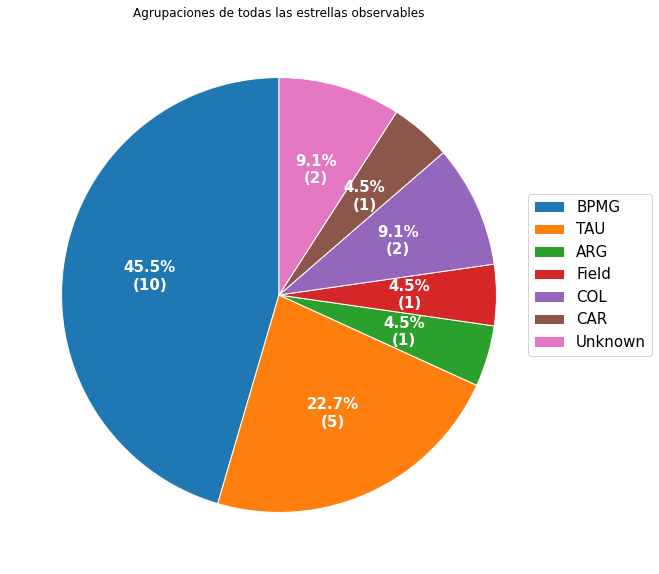

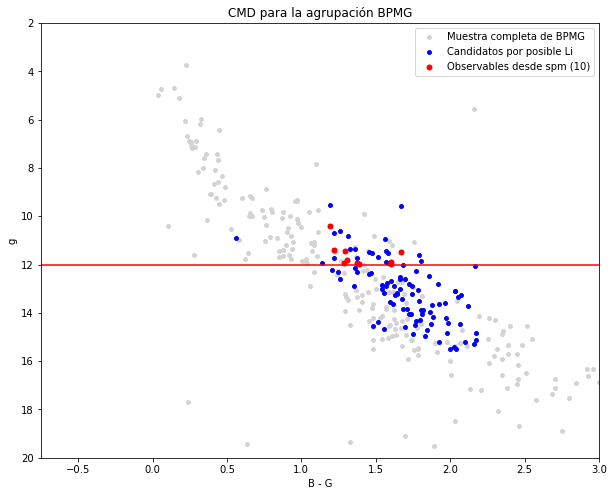

In [32]:
# -------------------------------------------------- #
#    ANÁLISIS DE TODAS LAS ESTRELLAS OBSERVABLES     #
# -------------------------------------------------- #

# Agrupaciones por cantidad en forma de diccionario

total_obs_num_groups = group_num_dict(total_main_catalogue)
total_obs_num_groups_sorted = sorted(total_obs_num_groups.items(), key=lambda item: item[1], reverse=True)

# Agrupaciones por nombre en forma de diccionario

def group_name_dict(catalogue):
    total_obs_name_groups = {}
    for star in catalogue:
        key = star['YNMG']
        value = star['ID']
        if key not in total_obs_name_groups:
            total_obs_name_groups[key] = []
        total_obs_name_groups[key].append(value)
    
    return total_obs_name_groups

total_obs_name_groups = group_name_dict(total_main_catalogue)
    
# Pie chart number function
    
def func(pct, allvalues):
    absolute = round(pct / 100.* np.sum(allvalues))
    return "{:.1f}%\n({:.0f})".format(pct, absolute)

# Pie chart function

def pie_chart_plot(data):
    quantities = []
    labels = []
    for key,value in data.items():
        labels.append(key)
        quantities.append(len(value))
        
    fig, ax = plt.subplots(figsize =(10, 10))
    wedges, texts, autotexts = ax.pie(quantities,
                                  autopct = lambda pct: func(pct, quantities),
                                  labels = labels,
                                  startangle = 90,
                                  wedgeprops={'linewidth': 5},
                                  textprops = dict(color ="w")
                                 )
    for wedge in wedges:
        wedge.set_path_effects([path_effects.Stroke(linewidth=1, foreground = 'w')])
        ax.legend(wedges, 
                labels,
                prop={'size':15},
                loc ="best",
                bbox_to_anchor=(1, 0.5, 0.2, 0.2)
                )
        plt.setp(autotexts, size = 15, weight = "bold")

pie_chart_plot(total_obs_name_groups)
plt.title("Agrupaciones de todas las estrellas observables", color="k")
plt.savefig(f"./graphics/{location.name}_piechart_total_obs_groups.jpg")
plt.show()

# CMD PARA BETA PICTORIS

for key, value in total_obs_num_groups_sorted:
    if key == "BPMG":
        plt.figure(figsize=(10,8))
        global_cmd_plot(key, 'phot_bp_absolute_mag', 'phot_g_absolute_mag', 'phot_g_mean_mag')
        plt.savefig(f"./graphics/{location.name}_CMD_{key}.jpg")
        plt.show()

In [ ]:
# ---------------------------------- #
#  CÓDIGO PARA UNA FECHA ESPECÍFICA  #
# ---------------------------------- #

dates_num = {}

ask = "Si"
while ask == "Si" or ask == "si":
        
    # DEFINIMOS LA FECHA A OBSERVAR 
    
    date = input("Ingrese una fecha para observar (YYYY-MM-DD): ")
    time_range = Time([date + " 06:00", date + " 12:00"])
    time_grid = time_grid_from_range(time_range)
    
    # DETERMINAMOS LAS OBSERVABILIDADES DE LOS TARGETS 
    obs_table, catalogue_ever_obs, main_catalogue, main_catalogue_no_vr = obs_function(constraints, main_catalogue_0, location, targets, time_range);
    
    ever_obs_groups = group_name_dict(main_catalogue) # agrupación a la que pertenecen aquellas que pueden ser observadas
   
    pie_chart_plot(ever_obs_groups)  # pie chart de dichas estrellas categorizadas por agrupacion
    plt.title("Agrupaciones de estrellas observables", color="k")
    plt.savefig(f"./graphics/{location.name}_piechart_ever_obs_groups.jpg")
    plt.show()
    
    no_vr_groups = group_name_dict(main_catalogue_no_vr) # agrupación a la que pertenecen aquellas que pueden ser observadas y que no poseen vr

    pie_chart_plot(no_vr_groups) # pie chart de dichas estrellas categorizadas por agrupacion
    plt.title("Agrupaciones de estrellas observables que no poseen velocidades radiales", color="k")
    plt.savefig(f"./graphics/{location.name}_piechart_ever_obs_no_vr_groups.jpg")
    plt.show()

    
    # GRÁFICO DE DISTRIBUCIÓN ESPACIAL DE LA MUESTRA OBSERVABLE QUE NO POSEE VELOCIDADES RADIALES 

    plt.figure(figsize=(10,10))
    plt.subplot(111, projection="aitoff")
    for candidate in main_catalogue:
        coords = SkyCoord(ra=candidate['RA'], dec=candidate['DEC'], unit='degree')
        ra = coords.ra.wrap_at(180 * u.deg).radian
        dec = coords.dec.radian
        if candidate['ID'] in main_catalogue_no_vr['ID']:
            plt.scatter(ra, dec, label = candidate['ID'] + ' *', s=60, linewidth=2, edgecolor='black')
        else:
            plt.scatter(ra, dec, label = candidate['ID'], s=60)

    plt.xlabel('RA [$^\circ$]')
    plt.ylabel('DEC [$^\circ$]')
    if len(main_catalogue) <= 10:
        plt.legend(shadow = True, loc='center left', bbox_to_anchor=(1, 0, 0.2, 1.2))
        plt.tight_layout()    

    plt.title("Distribución espacial de estrellas observables", fontsize='20', pad="30")
    plt.annotate(f"Observatorio: {location.name}", (0,0), (-35, -25), xycoords='axes fraction', textcoords='offset points', va='top', style="italic")
    plt.annotate("- Las estrellas con borde negro son aquellas que no presentan velocidades radiales",
                 (0,0), (-35, -40), xycoords='axes fraction', textcoords='offset points', va='top', style="italic")
    plt.grid(True)
    plt.savefig(f"./graphics/{location.name}_sky_plot_ever_obs_candidates_Li.jpg")
    plt.show()
    
    # Actualizamos los targets a la cantidad observable en la noche
    
    obs_targets = [FixedTarget(coord=SkyCoord(ra=RA*u.deg, dec=DEC*u.deg), name=ID)
                   for ID,RA,DEC,YNMG,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,teff_val,radius_val,lum_val,angDist,distances,phot_g_absolute_mag,phot_bp_absolute_mag,phot_rp_absolute_mag,ever_observable,always_observable,fraction_obs
                   in main_catalogue]

    # GRÁFICO DE MASA DE AIRE Y ALTITUD COMO FUNCIÓN DEL TIEMPO

    start_time = Time(date + ' 6:00:00')
    end_time = Time(date +  ' 12:00:00')
    delta_t = end_time - start_time
    observe_time = start_time + delta_t * np.linspace(-0.5, 1, 50)

    plt.figure(figsize=(6,6))    
    warnings.filterwarnings('ignore')
    plt.axhline(y = airmass, color = 'red', linestyle = '-')    
    plot_airmass(obs_targets, location, observe_time, altitude_yaxis = True)    
    plt.title("Masa de aire en función del tiempo para estrellas observables", pad=15)
    plt.savefig(f"./graphics/{location.name}_arimass_time_plot.jpg")
    plt.show()
    
    if date not in dates_num:
        dates_num[date] = len(main_catalogue)

    ask = input("Desea seguir observando en otra fecha? (si/no)")

for key,value in dates_num.items():
    print("El", key, "se pueden observar", value, "estrellas")

In [ ]:
# ------------------------------------------------------ #
#  GRAFICAMOS LAS POSICIONES DE LOS TARGETS EN EL TIEMPO #
# ------------------------------------------------------ #

print("Se graficarán las trayectorias de", len(obs_targets), "estrellas")

plt.figure(figsize=(6,6))
cmap = cm.Set1             # Cycle through this colormap

for i, target in enumerate(obs_targets):
    ax = plot_sky(target, location, time_grid, 
                  style_kwargs=dict(color=cmap(float(i)/len(obs_targets)), 
                                          label=target.name))

legend = ax.legend(loc='best', bbox_to_anchor=(1, 0.6, 0.6, 0.5))
legend.get_frame().set_facecolor('w')
plt.show()

#Graficar un circulo en 45º de altura

# ---------------------------------------------------------- #
#  GRAFICAMOS LAS CONDICIONES DE OBSERVABILIDAD EN EL TIEMPO #
# ---------------------------------------------------------- #

# Define range of times to observe between
start_time = Time('2021-08-01 00:00:00')
end_time = Time('2021-08-02 00:00:00')
time_resolution = 1 * u.hour

# Create grid of times from `start_time` to `end_time` with resolution `time_resolution`
time_grid = time_grid_from_range([start_time, end_time],
                                 time_resolution=time_resolution)

observability_grid = np.zeros((len(constraints), len(time_grid)))
for target in (obs_targets):   
    for i, constraint in enumerate(constraints):
        # Evaluate each constraint
        observability_grid[i, :] = constraint(location, target, times=time_grid)

    extent = [-0.5, -0.5+len(time_grid), -0.5, 2.5]

    # Create plot showing observability of the target:
    fig, ax = plt.subplots()
    ax.imshow(observability_grid)

    ax.set_yticks(range(0, 2))
    ax.set_yticklabels([c.__class__.__name__ for c in constraints])

    ax.set_xticks(range(len(time_grid)))
    ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in time_grid])

    ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
    ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(axis='x', which='minor', bottom='off')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    ax.tick_params(axis='y', which='minor', left='off')
    ax.set_xlabel('Time on {0} UTC'.format(time_grid[0].datetime.date()))
    fig.subplots_adjust(left=2, right=4)
    plt.title(target.name)
    plt.show()

In [ ]:
# Agregamos una última columna con un flag de observación que indica si la estrella fue o no observada
main_catalogue_obs['flag'] = 'No'

In [36]:
# ---------------------------- #
#    CREACIÓN DE TABLA FINAL   #
# ---------------------------- #

nymg = [] # array con los nymg
total_amount = [] # array con el total de los nymg
           
def build_amount(array, dic): # devuelve un array con dic.values de dic.keys que pertenecen al array
    amount = []           
    for group in array:
        if group in dic.keys():
            amount.append(dic[group])
        else:
            amount.append(0)
    return amount

# Categorizamos por grupos inciertos

uncertain_amount = 0 # cantidad total de estrellas con agrupaciones inciertas
uncertain_groups = {} # agrupaciones inciertas y sus cantidades
for key, value in total_groups.items():
    if ';' in key or '_' in key or '-' in key:
        uncertain_amount += total_groups[key]
        uncertain_groups[key] = total_groups[key]
        next
    else:
        nymg.append(key)
        total_amount.append(value)

total_li_groups = group_num_dict(main_catalogue_0) # dicccionario con los nymg a observar litio y sus cantidades 

total_li_amount = build_amount(nymg, total_li_groups) # array con el total de candidatos a obs litio      

def uncertain(dic1, dic2): # cantidad de elementos en dic1 que hay en dic2
    amount = 0
    for uncertain in dic1.keys():
        if uncertain in dic2.keys():
            amount += dic2[uncertain]
    return amount

uncertain_li_amount = uncertain(uncertain_groups,total_li_groups) # vemos cuantos pueden presentar litio

# Agregamos la info asociada a los uncertains a cada columna
total_amount.append(uncertain_amount)
total_li_amount.append(uncertain_li_amount)

if location.name == 'spm':
    observable_spm = build_amount(nymg, total_obs_num_groups)     
    observable_spm.append(uncertain(uncertain_groups, total_obs_num_groups))
if location.name == 'CASLEO':
    observable_casleo = build_amount(nymg, total_obs_num_groups)
    observable_casleo.append(uncertain(uncertain_groups, total_obs_num_groups))       
if location.name == 'Kitt Peak':
    observable_kpno = build_amount(nymg, total_obs_num_groups)
    observable_kpno.append(uncertain(uncertain_groups, total_obs_num_groups))       
if location.name == 'Cerro Tololo':
    observable_soar = build_amount(nymg, total_obs_num_groups)   
    observable_soar.append(uncertain(uncertain_groups, total_obs_num_groups))

nymg.append('Uncertain')
    
if observable_spm != [] and observable_casleo != [] and observable_kpno != [] and observable_soar != []:
    resume_table = Table([nymg, total_amount, total_li_amount, observable_spm, observable_casleo, observable_kpno, observable_soar],
                      names=('YNMG', 'total_amount', 'total_li_amount', 'observable_spm', 'observable_casleo', 'observable_kpno', 'observable_soar'))
    #resume_table.add_row(['Uncertain', uncertain_amount, uncertain_li_amount, uncertain_spm, uncertain_casleo, uncertain_kpno, uncertain_soar])
    resume_table.add_row(['TOTAL', np.sum(total_amount), np.sum(total_li_amount), np.sum(observable_spm), np.sum(observable_casleo),
                          np.sum(observable_kpno), np.sum(observable_soar)])
    ascii.write(resume_table, format='latex')  
    resume_table.write('./tables/resume_table.csv', overwrite=True)
    resume_table.write('./tables/resume_table.fits', overwrite=True)

NameError: name 'observable_casleo' is not defined

In [ ]:
# ---------------------------- #
#   ISOCRONAS Y TRAYECTORIAS   #
# ---------------------------- #

warnings.filterwarnings("ignore")

def baraffe_isochrones(mass,age): # Función para graficar isocronas
    file = "../data/baraffe_isochrone.csv"
    data_isoc = pd.read_csv(file, delimiter=",")
    iso = data_isoc[data_isoc["Age"] - age == min(np.abs(data_isoc["Age"] - age))]
    
    g_mag = pd.DataFrame(np.interp(mass, iso["Mass"], iso["G"]))
    b_mag = pd.DataFrame(np.interp(mass, iso["Mass"], iso["G_BP"]))
    r_mag = pd.DataFrame(np.interp(mass, iso["Mass"], iso["G_RP"]))
   
    g_mag.columns = ["Gmag"]
    b_mag.columns = ["G_BPmag"]
    r_mag.columns = ["G_RPmag"]
    result  = pd.concat([g_mag, b_mag, r_mag], axis=1)
    
    return result

def trajectories(mass, age): # Función para graficar trayectorias evolutivas
    file = "../data/baraffe_isochrone.csv"
    data_isoc = pd.read_csv(file, delimiter=",")
    iso = data_isoc[data_isoc["Mass"] - mass == min(np.abs(data_isoc["Mass"] - mass))]
    
    g_mag = pd.DataFrame(np.interp(age, iso["Age"], iso["G"]))
    b_mag = pd.DataFrame(np.interp(age, iso["Age"], iso["G_BP"]))
    r_mag = pd.DataFrame(np.interp(age, iso["Age"], iso["G_RP"]))
   
    g_mag.columns = ["Gmag"]
    b_mag.columns = ["G_BPmag"]
    r_mag.columns = ["G_RPmag"]
    result  = pd.concat([g_mag, b_mag, r_mag], axis=1)
    
    return result

# Masas y edades para isocronas
i_masses = np.arange(0, 100, 0.01)
i_ages = [1, 10, 20, 40, 100]

# Masas y edades para trayectorias
t_masses = [0.1, 0.3, 0.6, 0.8, 1.0, 1.2, 1.4]
t_ages = np.arange(1, 200, 1) 

"""
prominents_groups_dist = []

for group in prominents_groups:
    distances = []
    for i in range(0, len(main_catalogue_matched['distances'])):
        if group == main_catalogue_matched['YNMG'][i] and main_catalogue_matched['distances'][i] != "nan":        
            distances.append(main_catalogue_matched['distances'][i])
    prominents_groups_dist.append(np.mean(distances)) 
"""

for group in prominents_groups:
    plt.figure(figsize=(10,8))
    for age in i_ages:
        isochrone_data = baraffe_isochrones(i_masses, age)
        plt.plot(isochrone_data.G_BPmag - isochrone_data.Gmag, isochrone_data.Gmag, label = f"{age} Myr")      
    for mass in t_masses:
        trajectory = trajectories(mass, t_ages)
        plt.scatter(trajectory.G_BPmag - trajectory.Gmag, trajectory.Gmag, s=10, label = f'{mass} Ms')  
    global_cmd_plot(group, 'phot_bp_absolute_mag', 'phot_g_absolute_mag', 'phot_g_absolute_mag')
    plt.xlabel('B - G')
    plt.ylabel('G')
    plt.gca().set_xlim(0, 3)
    plt.gca().set_ylim(3, 14)
    plt.gca().invert_yaxis()
    plt.legend(loc = 'best')
    plt.savefig(f"./graphics/{location.name}_model_CMD_{group}.jpg")
    plt.show()
    
for key, value in total_obs_num_groups_sorted:
    if key == "BPMG":
        plt.figure(figsize=(10,8))
        global_cmd_plot(key, 'phot_bp_absolute_mag', 'phot_g_absolute_mag', 'phot_g_absolute_mag')
        for age in i_ages:
            isochrone_data = baraffe_isochrones(i_masses, age)
            plt.plot(isochrone_data.G_BPmag - isochrone_data.Gmag, isochrone_data.Gmag, label = f"{age} Myr")
        for mass in t_masses:
            trajectory = trajectories(mass, t_ages)
            plt.scatter(trajectory.G_BPmag - trajectory.Gmag, trajectory.Gmag, s=10, label = f'{mass} Ms')
        plt.xlabel('B - G')
        plt.ylabel('G')
        plt.gca().set_xlim(0, 3)
        plt.gca().set_ylim(3, 14)
        plt.gca().invert_yaxis()
        plt.legend(loc = 'best')
        plt.savefig(f"./graphics/{location.name}_model_CMD_{key}.jpg")
        plt.show()

In [78]:
# --------------------------------------- #
#   CALCULAMOS EL TIEMPO DE INTEGRACIÓN   #
# --------------------------------------- #

exposure_times = Table.read('../data/exposure_times/exposure_times_obs.csv', format='csv')   

# Filtramos por información del observatorio elegido
if location.name == 'CASLEO':
    exposure_times_location = exposure_times[exposure_times['observatory'] == 'casleo']
elif location.name == 'Cerro Tololo':
    exposure_times_location = exposure_times[exposure_times['observatory'] == 'soar']
else:
    exposure_times_location = exposure_times[exposure_times['observatory'] == location.name]

exposure_times_sec = np.round(np.interp(total_main_catalogue['phot_g_mean_mag'], exposure_times_location['mag_V'], exposure_times_location['exposure_time_sec']), 0)
exposure_times_sec = exposure_times_sec.astype(int)
total_exposure_time_sec = int(np.sum(exposure_times_sec))
            
total_exposure_time_hrs = np.round(total_exposure_time_sec / 3600, 1);
            
print(f"El tiempo total de integración necesario para observar las {len(total_main_catalogue)} estrellas es:", total_exposure_time_sec, "segundos.")
print("Su equivalente en horas es:", total_exposure_time_hrs)

total_main_catalogue.remove_column('exposure_time_sec')
if 'exposure_time_sec' not in total_main_catalogue.columns:
    total_main_catalogue['exposure_time_sec'] = exposure_times_sec

# Tiempos de integración por agrupación observable
total_obs_exposure_times_groups = {}
for key in total_obs_num_groups.keys():
    exposure_time_sec_per_key = 0
    for target in total_main_catalogue:
        if key == target['YNMG']:             
            exposure_time_sec_per_key += target['exposure_time_sec']
    total_obs_exposure_times_groups[key] = exposure_time_sec_per_key

print("Tiempos de integración para observar la totalidad de las poblaciones observables")
uncertain_exposure_times = 0
for key, value in total_obs_exposure_times_groups.items():        
    if key in uncertain_groups.keys():
        uncertain_exposure_times += value
    else:
        print(key, ":", value, "seg /", np.round(value / 3600, 1), "hrs")
        
if uncertain_exposure_times != 0:        
    print("Uncertain:", uncertain_exposure_times, "seg /", np.round(uncertain_exposure_times / 3600, 1), "hrs")

El tiempo total de integración necesario para observar las 22 estrellas es: 82120 segundos.
Su equivalente en horas es: 22.8
Tiempos de integración para observar la totalidad de las poblaciones observables
BPMG : 37043 seg / 10.3 hrs
TAU : 18262 seg / 5.1 hrs
ARG : 3637 seg / 1.0 hrs
Field : 3604 seg / 1.0 hrs
COL : 7825 seg / 2.2 hrs
CAR : 3934 seg / 1.1 hrs
Unknown : 7815 seg / 2.2 hrs


In [102]:
# ------------------------------------------------------ #
#   CONSTURIMOS UNA TABLA CON LOS TIEMPOS DE EXPOSICION  #
# ------------------------------------------------------ #

groups_obs = [] #array con las agrupaciones observables
groups_number_obs = [] #array con la cantidad de estrellas en agrupaciones observables
for key,value in total_obs_num_groups.items():
    if key not in uncertain_groups.keys():
        groups_obs.append(key)
        groups_number_obs.append(value)  

exposure_time_per_group_sec = []
for key, value in total_obs_exposure_times_groups.items():
    if key not in uncertain_groups.keys():
        exposure_time_per_group_sec.append(value)
    
uncertain_groups_num = uncertain(uncertain_groups, total_obs_num_groups);
if uncertain_groups_num != 0:
    groups_obs.append('Uncertain')
    groups_number_obs.append(uncertain_groups_num)
    exposure_time_per_group_sec.append(uncertain_exposure_times)
    
exposure_time_per_group_hrs = [np.round(i / 3600, 1) for i in exposure_time_per_group_sec]

if location.name == 'spm':
    overhead_spm = 600 #10 min
    total_overhead = [np.round((i * overhead_spm) / 3600, 1) for i in groups_number_obs]
    total_obs_time_per_group_hrs = np.round(np.add(exposure_time_per_group_hrs, total_overhead), 1)    
    exposure_times_table_spm = Table([groups_obs, groups_number_obs, exposure_time_per_group_hrs, total_obs_time_per_group_hrs],
                                      names=('YNMG', 'total_amount', 'exposure_time_hrs', 'total_time_hrs'))
    exposure_times_table_spm.add_row(['TOTAL', np.sum(groups_number_obs), total_exposure_time_hrs, np.round(np.sum(total_obs_time_per_group_hrs), 2)])
    ascii.write(exposure_times_table_spm, format='latex')  
    exposure_times_table_spm.write('./tables/exposure_times_table_spm.csv', overwrite=True)
    
if location.name == 'CASLEO':
    exposure_times_table_casleo = Table([groups_obs, groups_number_obs, exposure_time_per_group_hrs],
                                      names=('YNMG', 'total_amount', 'exposure_time_hrs'))
    exposure_times_table_casleo.add_row(['TOTAL', np.sum(groups_number_obs), total_exposure_time_hrs])
    ascii.write(exposure_times_table_casleo, format='latex')  
    exposure_times_table_casleo.write('./tables/exposure_times_table_casleo.csv', overwrite=True)
    
if location.name == 'Kitt Peak':
    overhead_kpno = 300 #5 min
    total_overhead = [np.round((i * overhead_kpno) / 3600, 1) for i in groups_number_obs]
    total_obs_time_per_group_hrs = np.round(np.add(exposure_time_per_group_hrs, total_overhead), 1)    
    exposure_times_table_kpno = Table([groups_obs, groups_number_obs, exposure_time_per_group_hrs, total_obs_time_per_group_hrs],
                                      names=('YNMG', 'total_amount', 'exposure_time_hrs', 'total_time_hrs'))
    exposure_times_table_kpno.add_row(['TOTAL', np.sum(groups_number_obs), total_exposure_time_hrs, np.round(np.sum(total_obs_time_per_group_hrs), 2)])
    ascii.write(exposure_times_table_kpno, format='latex')  
    exposure_times_table_kpno.write('./tables/exposure_times_table.kpno.csv', overwrite=True)
    
if location.name == 'Cerro Tololo':
    overhead_soar = 144 #2.4 min
    total_overhead = [np.round((i * overhead_soar) / 3600, 1) for i in groups_number_obs]
    total_obs_time_per_group_hrs = np.round(np.add(exposure_time_per_group_hrs, total_overhead), 1)
    exposure_times_table_soar = Table([groups_obs, groups_number_obs, exposure_time_per_group_hrs, total_obs_time_per_group_hrs],
                                      names=('YNMG', 'total_amount', 'exposure_time_hrs', 'total_time_hrs'))
    exposure_times_table_soar.add_row(['TOTAL', np.sum(groups_number_obs), total_exposure_time_hrs, np.round(np.sum(total_obs_time_per_group_hrs), 2)])
    ascii.write(exposure_times_table_soar, format='latex')  
    exposure_times_table_soar.write('./tables/exposure_times_table_soar.csv', overwrite=True)  

\begin{table}
\begin{tabular}{cccc}
YNMG & total_amount & exposure_time_hrs & total_time_hrs \\
BPMG & 10 & 10.3 & 12.0 \\
TAU & 5 & 5.1 & 5.9 \\
ARG & 1 & 1.0 & 1.2 \\
Field & 1 & 1.0 & 1.2 \\
COL & 2 & 2.2 & 2.5 \\
CAR & 1 & 1.1 & 1.3 \\
Unknown & 2 & 2.2 & 2.5 \\
TOTAL & 22 & 22.8 & 26.6 \\
\end{tabular}
\end{table}


In [104]:
# ---------------------------------------------------------------- #
#   CONSTURIMOS UNA TABLA CON LOS CANDIDATOS DE BPMG Y UNCERTAIN   #
# ---------------------------------------------------------------- #

def bpmg_from_obs():
    bpmg_table = total_main_catalogue[total_main_catalogue['YNMG'] == 'BPMG']
    bpmg_table.keep_columns(['ID', 'RA', 'DEC', 'phot_g_mean_mag', 'radial_velocity', 'teff_val', 'radius_val', 'lum_val', 'distances', 'fraction_obs', 'exposure_time_sec'])
    bpmg_table['RA'] = np.round(bpmg_table['RA'], 4)
    bpmg_table['DEC'] = np.round(bpmg_table['DEC'], 3)
    bpmg_table['phot_g_mean_mag'] = np.round(bpmg_table['phot_g_mean_mag'], 2)
    bpmg_table['teff_val'] = np.round(bpmg_table['teff_val'], 0)
    bpmg_table['distances'] = np.round(bpmg_table['distances'], 2)
    bpmg_table['fraction_obs'] = np.round(bpmg_table['fraction_obs'] * 100, 1)
    
    return bpmg_table

def uncertain_from_obs():
    uncertain_id = []
    uncertain_nymg = []
    uncertain_ra = []
    uncertain_dec = []
    uncertain_mag = []
    uncertain_rv = []
    uncertain_teff = []
    uncertain_rad = []
    uncertain_lum = []
    uncertain_dist = []
    uncertain_obs = []
    uncertain_exp = []

    for target in total_main_catalogue:
        if target['YNMG'] in uncertain_groups.keys():
            uncertain_id.append(target['ID'])
            uncertain_nymg.append(target['YNMG'])
            uncertain_ra.append(target['RA'])
            uncertain_dec.append(target['DEC'])
            uncertain_mag.append(target['phot_g_mean_mag'])
            uncertain_rv.append(target['radial_velocity'])
            uncertain_teff.append(target['teff_val'])
            uncertain_rad.append(target['radius_val'])
            uncertain_lum.append(target['lum_val'])
            uncertain_dist.append(target['distances'])
            uncertain_obs.append(target['fraction_obs'])
            uncertain_exp.append(target['exposure_time_sec'])
     
    uncertain_table = Table([uncertain_id, uncertain_nymg, uncertain_ra, uncertain_dec, uncertain_mag, uncertain_rv, uncertain_teff, uncertain_rad, 
                                   uncertain_lum, uncertain_dist, uncertain_obs, uncertain_exp], 
                                    names = ('ID', 'YNMG', 'RA', 'DEC', 'phot_mean_g_mag', 'radial_velocity', 'teff_val', 'radius_val', 'lum_val', 'distances', 
                                               'fraction_obs', 'exposure_time_sec'))
    uncertain_table['distances'] = np.round(uncertain_table['distances'], 2)
    uncertain_table['fraction_obs'] = np.round(uncertain_table['fraction_obs'], 2)
    
    return uncertain_table

if location.name == 'spm':
    bpmg_from_spm = bpmg_from_obs()
    ascii.write(bpmg_from_spm, format='latex')  
    bpmg_from_spm.write('./tables/bpmg_from_spm.csv', overwrite=True)
    
    uncertain_from_spm = uncertain_from_obs()
    ascii.write(uncertain_from_spm, format='latex')  
    uncertain_from_spm.write('./tables/uncertain_from_spm.csv', overwrite=True)
    
if location.name == 'CASLEO':
    bpmg_from_casleo = bpmg_from_obs()
    ascii.write(bpmg_from_casleo, format='latex')  
    bpmg_from_casleo.write('./tables/bpmg_from_casleo.csv', overwrite=True)
    
    uncertain_from_casleo = uncertain_from_obs()
    ascii.write(uncertain_from_casleo, format='latex')  
    uncertain_from_casleo.write('./tables/uncertain_from_casleo.csv', overwrite=True)
    
if location.name == 'Kitt Peak':    
    bpmg_from_kpno = bpmg_from_obs()
    ascii.write(bpmg_from_kpno, format='latex')  
    bpmg_from_kpno.write('./tables/bpmg_from_kpno.csv', overwrite=True)
    
    uncertain_from_kpno = uncertain_from_obs()
    ascii.write(uncertain_from_kpno, format='latex')  
    uncertain_from_kpno.write('./tables/uncertain_from_kpno.csv', overwrite=True)
    
if location.name == 'Cerro Tololo':
    bpmg_from_soar = bpmg_from_obs()
    ascii.write(bpmg_from_soar, format='latex')  
    bpmg_from_soar.write('./tables/bpmg_from_soar.csv', overwrite=True)
    
    uncertain_from_soar = uncertain_from_obs()
    ascii.write(uncertain_from_soar, format='latex')  
    uncertain_from_soar.write('./tables/uncertain_from_soar.csv', overwrite=True)

\begin{table}
\begin{tabular}{ccccccccccc}
ID & RA & DEC & phot_g_mean_mag & radial_velocity & teff_val & radius_val & lum_val & distances & fraction_obs & exposure_time_sec \\
dasilva_etal_2009_14 & 83.0188 & -3.091 & 10.42 & 24.45 & 4073.0 & 0.62 & 0.096 & 34.56 & 7.83 & 3768 \\
gagne_174 & 23.8084 & -7.214 & 11.99 &  & 3688.0 &  &  & 37.28 & 6.39 & 3605 \\
gagne_178 & 36.8673 & 30.978 & 11.44 & 5.31 & 3852.0 & 0.56 & 0.061 & 40.9 & 13.53 & 3826 \\
gagne_5263 & 42.9759 & 22.458 & 11.9 &  & 3768.0 &  &  & 27.08 & 12.73 & 3638 \\
gagne_5355 & 61.4122 & 5.745 & 11.8 &  & 3824.0 &  &  & 36.73 & 10.11 & 3680 \\
gagne_6646 & 75.4862 & 1.145 & 11.48 &  & 3501.0 &  &  & 25.28 & 9.04 & 3807 \\
gagne_6727 & 30.4452 & 1.288 & 11.96 &  & 3815.0 & 0.55 & 0.057 & 49.58 & 9.15 & 3616 \\
gagne_6728 & 30.4458 & 1.285 & 11.93 &  & 3552.0 & 0.7 & 0.07 & 49.38 & 9.15 & 3629 \\
gagne_6826 & 177.9862 & 7.524 & 11.4 &  & 3800.0 & 0.73 & 0.101 & 50.83 & 10.43 & 3841 \\
gagne_6871 & 334.678 & 33.354 & 11.92 

In [83]:
galah_cat = Table.read(r'C:\Users\User\Downloads\galah_catalogue', format='csv')
apogee_cat = Table.read(r'C:\Users\User\Downloads\apogee_catalogue', format='csv')

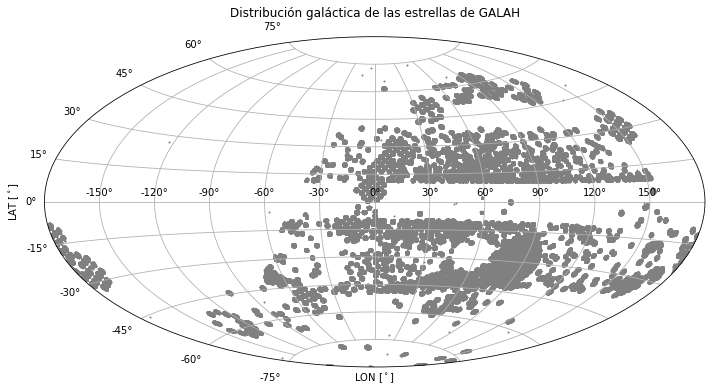

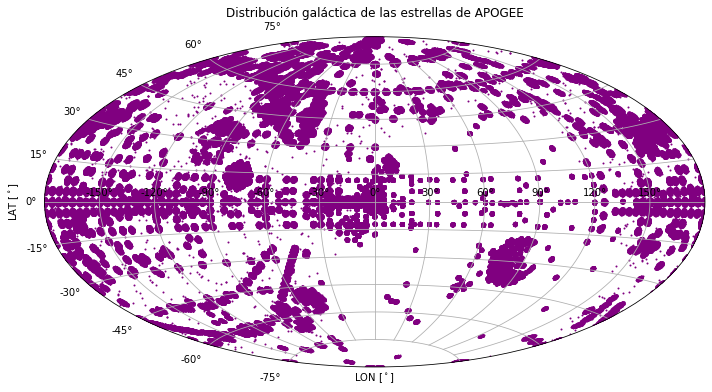

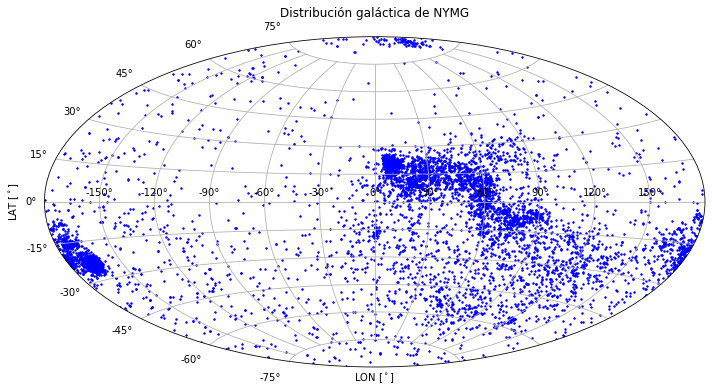

In [110]:
from astropy.coordinates import Galactic

# GALACTIC PLOT OF GALAH
plt.figure(figsize=(10,10))
plt.subplot(111, projection="aitoff")

galah_coords = SkyCoord(ra=galah_cat['ra_dr2'], dec=galah_cat['dec_dr2'], unit='degree')
galah_gal_coords = galah_coords.galactic
galah_lon = galah_gal_coords.l.wrap_at(180*u.deg).radian
galah_lat = galah_gal_coords.b.radian
plt.scatter(-galah_lon, galah_lat, color = 'grey', s=1, linewidth=1)

plt.grid(True)
plt.xlabel('LON [$^\circ$]')
plt.ylabel('LAT [$^\circ$]')
plt.tight_layout()
plt.title("Distribución galáctica de las estrellas de GALAH", pad=20)
plt.savefig(f"./graphics/galactic_plot_galah.jpg")


# GALACTIC PLOT OF APOGEE
plt.figure(figsize=(10,10)),
plt.subplot(111, projection="aitoff")

apogee_coords= SkyCoord(ra=apogee_cat['RA'], dec=apogee_cat['DEC'], unit='degree')
apogee_gal_coords = apogee_coords.galactic
apogee_lon = apogee_gal_coords.l.wrap_at(180*u.deg).radian
apogee_lat = apogee_gal_coords.b.radian
plt.scatter(-apogee_lon, apogee_lat, color = 'purple', s=1, linewidth=1)

plt.grid(True)
plt.xlabel('LON [$^\circ$]')
plt.ylabel('LAT [$^\circ$]')
plt.tight_layout()
plt.title("Distribución galáctica de las estrellas de APOGEE", pad=20)
plt.savefig(f"./graphics/galactic_plot_apogee.jpg")


# GALACTIC PLOT OF NYMG
plt.figure(figsize=(10,10)),
plt.subplot(111, projection="aitoff")

gagne_coords = SkyCoord(ra=main_catalogue_matched['RA'], dec=main_catalogue_matched['DEC'], unit='degree')
gagne_gal_coords = gagne_coords.galactic
gagne_lon = gagne_gal_coords.l.wrap_at(180*u.deg).rad
gagne_lat = gagne_gal_coords.b.radian
plt.scatter(-gagne_lon, gagne_lat, color = 'blue', s=2, linewidth=1)

plt.grid(True)
plt.xlabel('LON [$^\circ$]')
plt.ylabel('LAT [$^\circ$]')
plt.tight_layout()
plt.title("Distribución galáctica de NYMG", pad=20)
plt.savefig(f"./graphics/galactic_plot_nymg.jpg")